In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sqlite3
import seaborn as sns
from dataclasses import dataclass, field
from typing import Dict, Tuple, Iterable
from Utils.Plot_Helper import plot_1d_data, plot_gaussian_node
from Utils.Metrics import rmse, nll, node_metrics
from Filters.KalmanFilter import KalmanFilterSmoother
from Systems import UniformNonlinearGrowthModel, BearingsOnlyTracking, BearingsOnlyTrackingTurn
from MomentMatching.Estimator import Estimator
from MomentMatching import UnscentedTransform, MonteCarloTransform, TaylorTransform
from ExpectationPropagation.Nodes import build_nodes, node_estimator, node_system
from ExpectationPropagation.Iterations import ep_iterations
from Experiments.EP_FullSweep import select_transform

In [5]:
plt.ioff()

def select_data(experiment):
    if experiment == 'ungm':
        exp_table = 'UNGM_EXP'
        con = sqlite3.connect("../log/ungm_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bot':
        exp_table = 'BOT_EXP'
        con = sqlite3.connect("../log/bot_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bott':
        exp_table = 'BOTT_EXP'
        con = sqlite3.connect("../log/bott_final.db", detect_types=sqlite3.PARSE_DECLTYPES)

    cursor = con.cursor()
    return exp_table, cursor

    
@dataclass
class PlotConfig:
    figsize: Tuple = (12, 5)
    xlabel_fontsize: int = 16
    ylabel_fontsize: int = 16
    title_fontsize: int = 16
    legend_fontsize: int = 12
    xticks: Iterable = None
    xtick_labels: Iterable = None
    xtick_labelsize: int = 16
    yticks: Iterable = None
    ytick_labels: Iterable = None
    ytick_labelsize: int = 16
    cbar_ticks: Iterable = None
    cbar_tick_labels: Iterable = None
    vmin_rmse: float = None
    vmax_rmse: float = None
    vmin_nll: float = None
    vmax_nll: float = None
    xmin: float = None
    xmax: float = None


methods = [None, 'none','nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
           

def plot_power_sweep(plot_config, img, methods, title=None, metric='rmse', ax=None):

    plt.rcParams['xtick.labelsize'] = plot_config.xtick_labelsize
    plt.rcParams['ytick.labelsize'] = plot_config.ytick_labelsize
    if ax is None:
        plt.figure(figsize=plot_config.figsize)
        ax = plt.gca()

    if metric == 'rmse':
        vmin, vmax = plot_config.vmin_rmse, plot_config.vmax_rmse
    else:
        vmin, vmax = plot_config.vmin_nll, plot_config.vmax_nll
    im = ax.imshow(img, interpolation=methods[4],
                   extent=[0.1,1,0.1,1], cmap='magma_r', #sns.cubehelix_palette(8, as_cmap=True),
                   vmax=vmax, vmin=vmin, origin='lower')

    ax.set_xlabel('Power', fontsize=plot_config.xlabel_fontsize)
    ax.set_ylabel('Damping', fontsize=plot_config.ylabel_fontsize)
    if title is not None:
        ax.set_title(title, fontsize=plot_config.title_fontsize)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if plot_config.cbar_ticks is not None:
        cbar = plt.colorbar(im, cax=cax, ticks=plot_config.cbar_ticks)
        if plot_config.cbar_tick_labels is not None:
            cbar.ax.set_yticklabels(plot_config.cbar_tick_labels)
    else:
        plt.colorbar(im, cax=cax)
    
    plt.tight_layout()
    

def make_image_data(cursor, table, transform, seed, iters=10):
    all_iters = """
                    SELECT RMSE, NLL, Power, Damping from 
                    {}
                    WHERE Transform = '{}' AND Seed = {} AND Iter = {}
                """
    cursor.execute(all_iters.format(table, transform, seed, iters))
    data = cursor.fetchall()
    rms, nl, p, d = zip(*data)
    nl = np.array(nl)
    rms = np.array(rms)
    p = np.array(p)
    d = np.array(d)
    p = p.reshape(19, 19)
    d = d.reshape(19, 19)
    p_nll = nl.reshape(19, 19)
    p_rmse = rms.reshape(19, 19)
    
    return p_rmse, p_nll, p, d


def all_seeds_image(cursor, table, transform, iters=50, seeds=None):
  all_prmse = []
  all_pnll = []
  cursor.execute(f"SELECT DISTINCT Seed from {table}")
  if seeds is None:
    seeds = cursor.fetchall()
    seeds = [seed[0] for seed in seeds]
  for seed in seeds:
    rmse, nll, p, d = make_image_data(cursor, table, transform, seed, iters=iters)
    all_prmse.append(rmse)
    all_pnll.append(nll)
  prmse = np.array(all_prmse)
  pnll = np.array(all_pnll)

  return np.mean(prmse, axis=0), np.mean(pnll, axis=0), p, d


def plot_sweep(cursor, plot_config, table, transform, iters=10, metric='rmse', title=False, ax=None, seeds=None):
    p_rmse, p_nll, p, d = all_seeds_image(cursor, table, transform, iters=iters, seeds=seeds)
    if title == True:
        title = f'Transform = {transform}'
    else:
        title = None
    if metric == 'rmse':
        plot_power_sweep(plot_config, (p_rmse.T), methods, title, metric=metric, ax=ax)
    else:
        plot_power_sweep(plot_config, (p_nll.T), methods, title, metric=metric, ax=ax)


def plot_all_transforms(cursor, plot_config, table, iters=10, metric='rmse'):
    transform_list = ['TT', 'UT', 'MCT']
    fig, axs = plt.subplots(1, 3, figsize=plot_config.figsize) #figsize=(26, 9)
    for i, trans in enumerate(transform_list):
        plot_sweep(cursor, plot_config, table, trans, iters=iters, metric=metric, title=True, ax=axs[i])
    if metric == 'rmse':
        plt.suptitle('RMSE', fontweight='bold', fontsize=30)
    else:
        plt.suptitle('NLL', fontweight='bold', fontsize=30)
    plt.tight_layout()

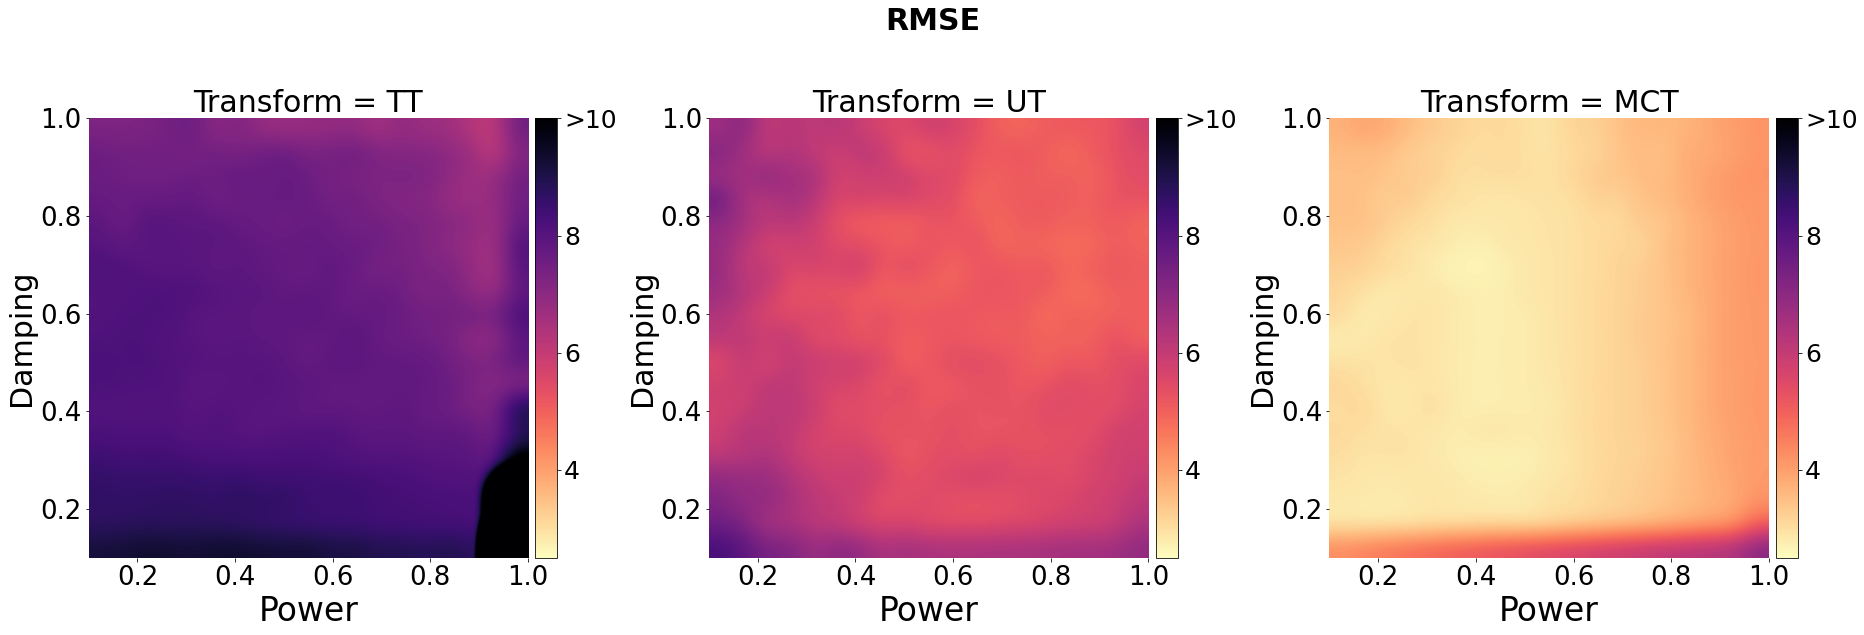

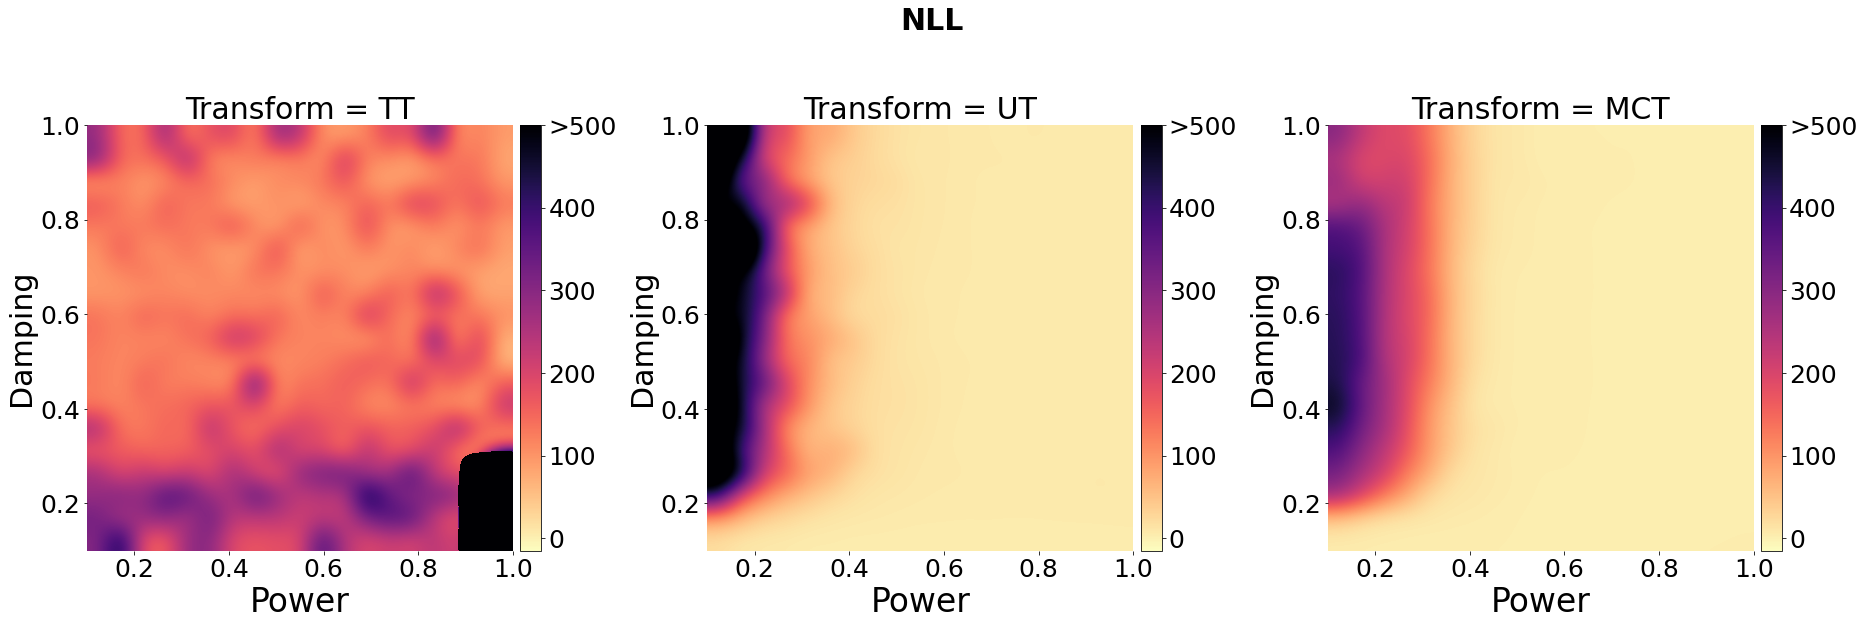

In [8]:
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(26,9),
                         vmin_rmse=2.5, vmax_rmse=10.0,
                         vmin_nll=-15.0, vmax_nll=500.0,
                         xlabel_fontsize=33, ylabel_fontsize=30,
                         title_fontsize=30,
                         xtick_labelsize=25, ytick_labelsize=25)
                         
iter = 50

cbar_ticks = np.linspace(0, 10, 6)
cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
plot_config.cbar_ticks=cbar_ticks
plot_config.cbar_tick_labels=cbar_tickslabel
plot_all_transforms(cursor, plot_config, exp_table, iter, 'rmse')

cbar_ticks = np.linspace(0, 500, 6)
cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
plot_config.cbar_ticks=cbar_ticks
plot_config.cbar_tick_labels=cbar_tickslabel
plot_all_transforms(cursor, plot_config, exp_table, iter, 'nll')

plt.show()

In [7]:
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(9,7),
                         vmin_rmse=2.5, vmax_rmse=10.0,
                         vmin_nll=-15.0, vmax_nll=500,
                         xlabel_fontsize=30, ylabel_fontsize=28,
                         title_fontsize=28,
                         xtick_labelsize=26, ytick_labelsize=26)

trans_types = ['TT', 'UT', 'MCT']
iter = 50
for trans in trans_types:
    cbar_ticks = np.linspace(0, 10, 6)
    cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
    plot_config.cbar_ticks=cbar_ticks
    plot_config.cbar_tick_labels=cbar_tickslabel
    cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
    plot_sweep(cursor, plot_config, exp_table, trans, iters=iter, metric='rmse')
    plt.savefig(f"figs/Heatmap_{experiment}_trans_{trans}_iter_{iter}_RMSE.pdf")

    cbar_ticks = np.linspace(0, 500, 6)
    cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
    plot_config.cbar_ticks=cbar_ticks
    plot_config.cbar_tick_labels=cbar_tickslabel
    cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
    plot_sweep(cursor, plot_config, exp_table, trans, iters=iter, metric='nll')
    plt.savefig(f"figs/Heatmap_{experiment}_trans_{trans}_iter_{iter}_NLL.pdf")

plt.close('all') # plt.show()